## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mcmc_l1 import sample

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import arviz as az
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

## Data loading

In [5]:
f = open("./data/spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("./data/spambase.data", header=None) 
df.columns = headers
df.insert(0, "intercept", 1)
df["class"] = df["class"].replace(0,-1)

df.sample(5)

,intercept,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
4120,1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.000,1,8,-1
2970,1,0.0,0.0,0.00,0.0,1.19,0.0,0.0,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.733,14,52,-1
4209,1,0.0,0.0,1.17,0.0,0.00,0.0,0.0,0.00,0.00,...,0.000,0.284,0.0,0.284,0.213,0.071,1.565,12,72,-1
2698,1,0.0,0.0,0.00,0.0,7.14,0.0,0.0,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.600,4,8,-1
2230,1,0.0,0.0,0.15,0.0,0.30,0.0,0.0,0.15,0.15,...,0.023,0.023,0.0,0.000,0.000,0.000,2.677,58,415,-1


In [6]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [7]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 58)

In [8]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma[0] = 1
sigma.shape

(58,)

## Study

In [9]:
n_chains = 3
T = 100
n_start = 20 # burn in

In [10]:
nu = 1

betas1 = np.zeros((T,k))

for _ in range(n_chains):
    betas1 += sample(X, sigma, rng, nu, T)

betas1 /= n_chains
betas1 = betas1[n_start:]
std_betas1 = betas1.mean(axis=0)*sigma

In [11]:
nu = 1e-3

betas2 = np.zeros((T,k))

for _ in range(n_chains):
    betas2 += sample(X, sigma, rng, nu, T)

betas2 /= n_chains
betas2 = betas2[n_start:]
std_betas2 = betas2.mean(axis=0)*sigma

In [12]:
lower_bound1 = np.quantile(betas1, 0.025, axis = 0)
lower_bound2 = np.quantile(betas2, 0.025, axis = 0)

upper_bound1 = np.quantile(betas1, 1-0.025, axis = 0)
upper_bound2 = np.quantile(betas2, 1-0.025, axis = 0)

err1 = upper_bound1-lower_bound1
err2 = upper_bound2-lower_bound2

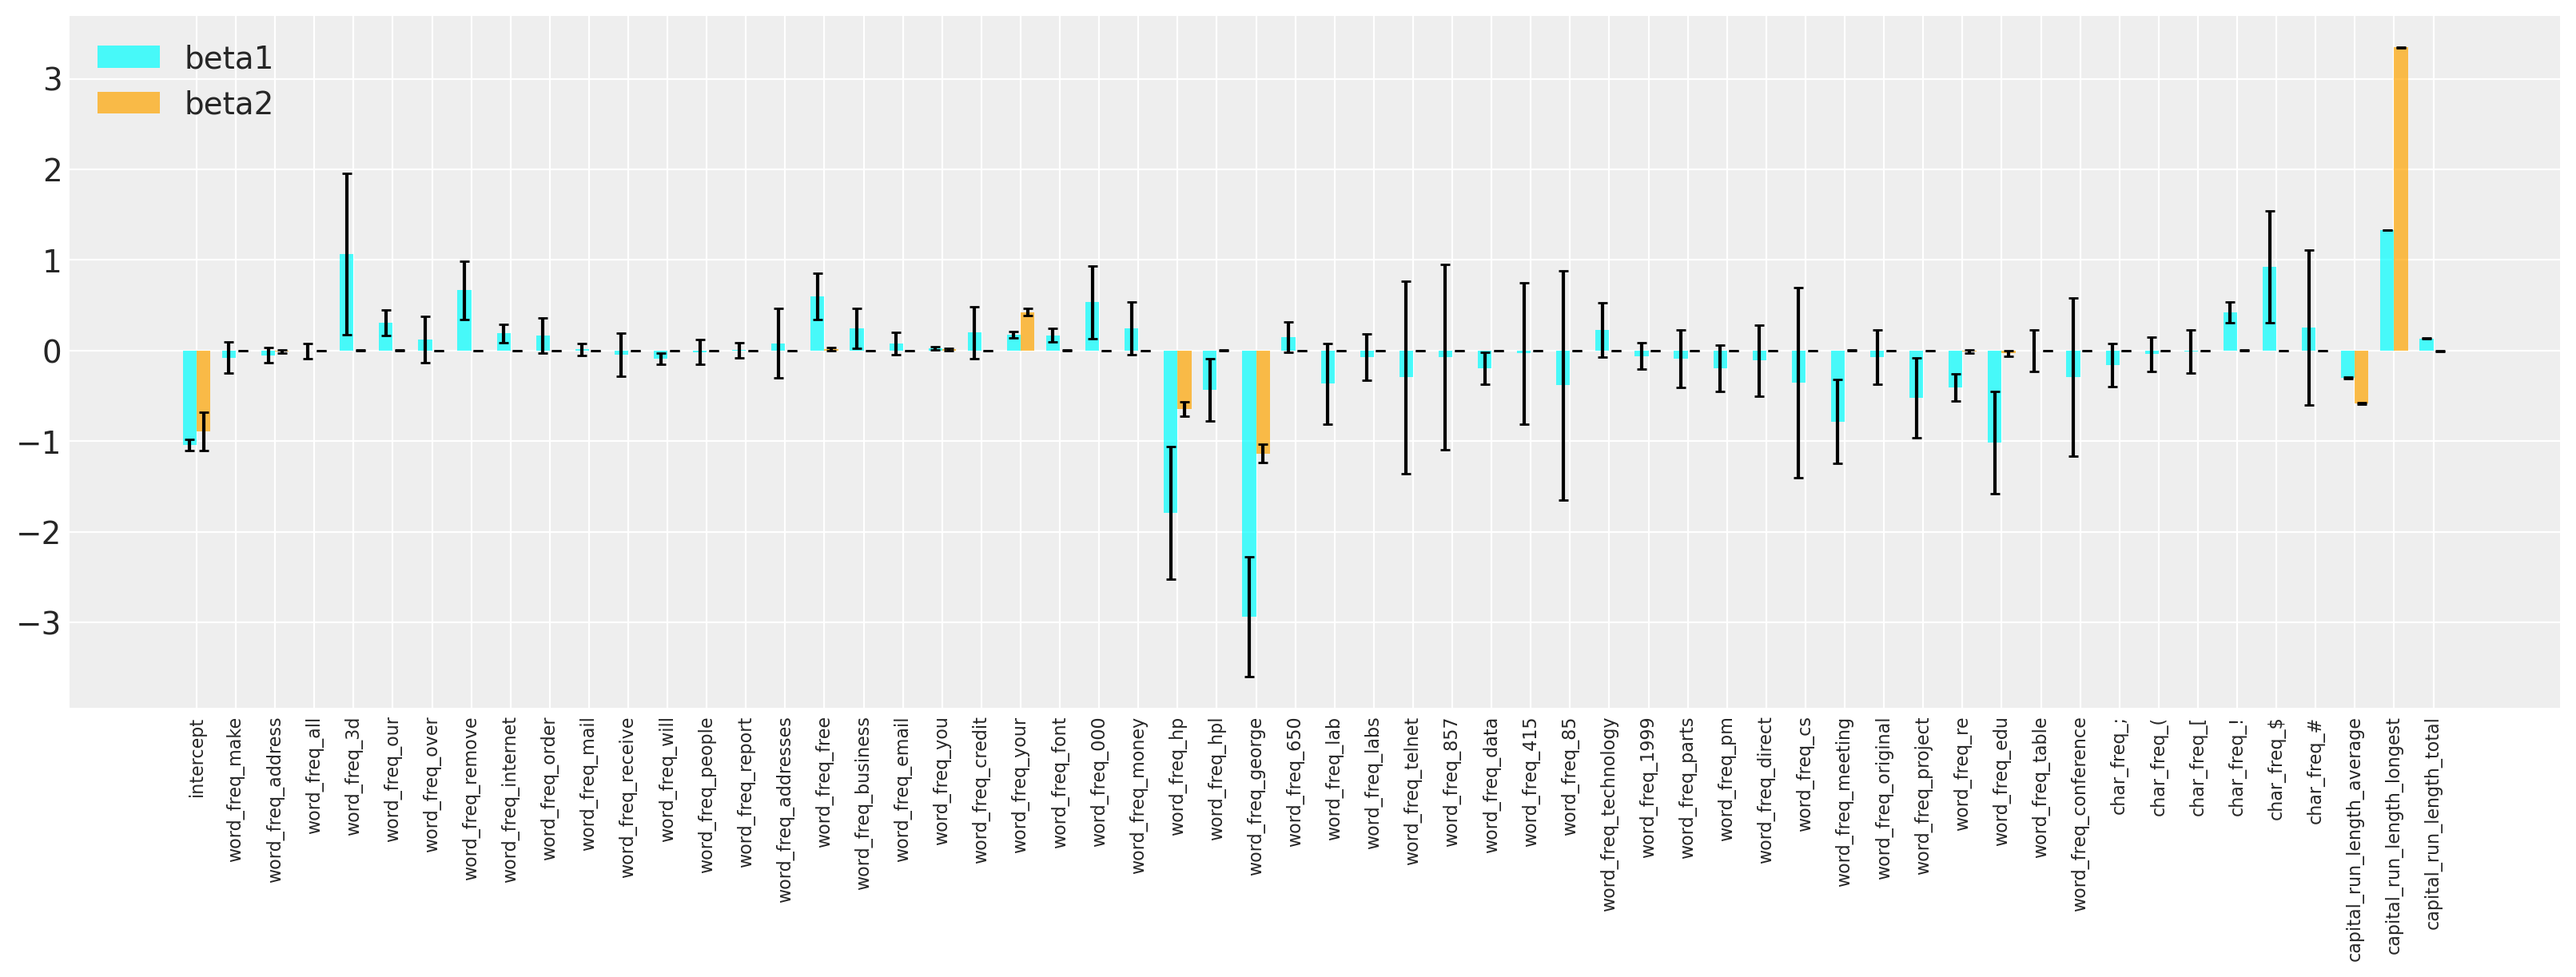

In [26]:
x = np.arange(k)
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x - width / 2, std_betas1, width, label='beta1', alpha=.7, yerr=err1, capsize=2, color="cyan")
bar2 = ax.bar(x + width / 2, std_betas2, width, label='beta2', alpha=.7, yerr=err2, capsize=2, color="orange")

ax.set_xticks(x)
ax.set_xticklabels(df.columns[:-1], fontsize=8)

plt.xticks(rotation=90)
# plt.yscale("log")
plt.legend()
plt.show()